# Data Exploration

## Overview
This notebook performs data exploration and preprocessing for GOES images. The workflow includes data loading, quality control, temporal alignment.

### Libraries

In [8]:
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

### Parameters

In [9]:
LON, LAT = -74.0659, 4.6043
IN_SIZE  = 224
OUT_SIZE = 32
CHANNELS = range(1,17)

FILES = sorted(glob("../data_raw/datos_GOES/OR_ABI-L2-MCMIPF-M6_G16_*.nc"))[:200]  # procesa hasta 200 archivos (ajusta)
OUT_DIR = Path("../data_interim/goes_dataset")
OUT_DIR.mkdir(parents=True, exist_ok=True)

### Functions

In [10]:
# Utilidades pequeñas inline (sin sobre-modular)
def ensure_utc(ts_like):
    ts = pd.Timestamp(ts_like)
    return ts.tz_localize("UTC") if ts.tz is None else ts.tz_convert("UTC")

from scipy.ndimage import zoom

def resize_32(a):
    sy = OUT_SIZE / a.shape[0]
    sx = OUT_SIZE / a.shape[1]
    return zoom(a, (sy, sx), order=1).astype("float32")

def normalize(a, ch):
    a = a.astype("float32")
    if ch == 1:                  # visible
        return np.clip(a, 0, 1)
    return (np.clip(a, 180, 330) - 180) / 150.0  # IR → [0,1]

# Lon/lat → coords GEOS del archivo (m)
import pyproj
def lonlat_to_geos_xy(ds, lon, lat):
    gip = ds["goes_imager_projection"]
    sat_h  = float(gip.perspective_point_height)
    lon_0  = float(gip.longitude_of_projection_origin)
    sweep  = str(gip.sweep_angle_axis)
    geos = pyproj.CRS.from_proj4(f"+proj=geos +h={sat_h} +lon_0={lon_0} +sweep={sweep} +ellps=WGS84")
    wgs  = pyproj.CRS.from_epsg(4326)
    P = pyproj.Transformer.from_crs(wgs, geos, always_xy=True)
    return P.transform(lon, lat)  # (Xc, Yc) en metros

### Demo

In [11]:
rows_patches = []   # cada fila: dict {'time': ts, '1': arr32, ..., '16': arr32}
rows_features = []  # cada fila: dict {'time': ts, 'C01_mean':..., 'C01_std':..., ...}

for nc_path in FILES:
    try:
        ds = xr.open_dataset(nc_path)

        # Ejes x,y en metros
        sat_h = float(ds["goes_imager_projection"].perspective_point_height)
        x = ds["x"].values * sat_h
        y = ds["y"].values * sat_h

        # Timestamp
        ts_attr = (ds.attrs.get("time_coverage_start")
                   or ds.attrs.get("t")
                   or next((ds[v].attrs.get("time_coverage_start")
                            for v in ds.data_vars if "time_coverage_start" in ds[v].attrs), None))
        if ts_attr is None:
            ds.close(); continue
        ts = ensure_utc(ts_attr)

        # Centro ROI → índices
        Xc, Yc = lonlat_to_geos_xy(ds, LON, LAT)
        ix = int(np.argmin((x - Xc)**2))
        iy = int(np.argmin((y - Yc)**2))

        half = IN_SIZE // 2
        xs = slice(max(ix-half, 0), min(ix+half, x.size))
        ys = slice(max(iy-half, 0), min(iy+half, y.size))

        # Extrae y arma tensor (C,32,32)
        chan_dict = {}
        feat_dict = {}
        for ch in CHANNELS:
            var = f"CMI_C{ch:02d}"
            if var not in ds:
                # relleno si falta canal
                arr32 = np.full((OUT_SIZE, OUT_SIZE), np.nan, np.float32)
                chan_dict[str(ch)] = arr32
                feat_dict[f"C{ch:02d}_mean"] = np.nan
                feat_dict[f"C{ch:02d}_std"]  = np.nan
                continue

            patch = ds[var].isel(x=xs, y=ys).values  # (y,x)
            # pad si borde
            ph, pw = patch.shape
            if (ph, pw) != (IN_SIZE, IN_SIZE):
                pad_y = max(0, IN_SIZE - ph)
                pad_x = max(0, IN_SIZE - pw)
                patch = np.pad(patch, ((0,pad_y),(0,pad_x)), mode="edge")

            arr32 = resize_32(patch)
            arr32 = normalize(arr32, ch)

            chan_dict[str(ch)] = arr32
            feat_dict[f"C{ch:02d}_mean"] = float(np.nanmean(arr32))
            feat_dict[f"C{ch:02d}_std"]  = float(np.nanstd(arr32))

        ds.close()

        # Guarda fila
        chan_dict["time"] = ts
        rows_patches.append(chan_dict)

        feat_dict["time"] = ts
        rows_features.append(feat_dict)

    except Exception as e:
        print("⚠️", nc_path, "→", e)

In [12]:
if not rows_patches:
    raise RuntimeError("No se generaron parches (revisa patrón FILES o permisos).")

sat_raw = pd.DataFrame(rows_patches).set_index("time").sort_index()
sat_feat = pd.DataFrame(rows_features).set_index("time").sort_index()

print("sat_raw shape:", sat_raw.shape)   # columnas: '1'..'16' con arrays (32×32)
print("sat_feat shape:", sat_feat.shape) # columnas: Cxx_mean/std

# Persistencia
sat_raw.to_pickle(OUT_DIR / "goes_patches.pkl")
sat_feat.to_parquet(OUT_DIR / "goes_features.parquet", engine="pyarrow", compression="zstd")
print("✅ Guardado:", OUT_DIR / "goes_patches.pkl")
print("✅ Guardado:", OUT_DIR / "goes_features.parquet")

sat_raw shape: (1, 16)
sat_feat shape: (1, 32)
✅ Guardado: ../data_interim/goes_dataset/goes_patches.pkl
✅ Guardado: ../data_interim/goes_dataset/goes_features.parquet


### Graphics

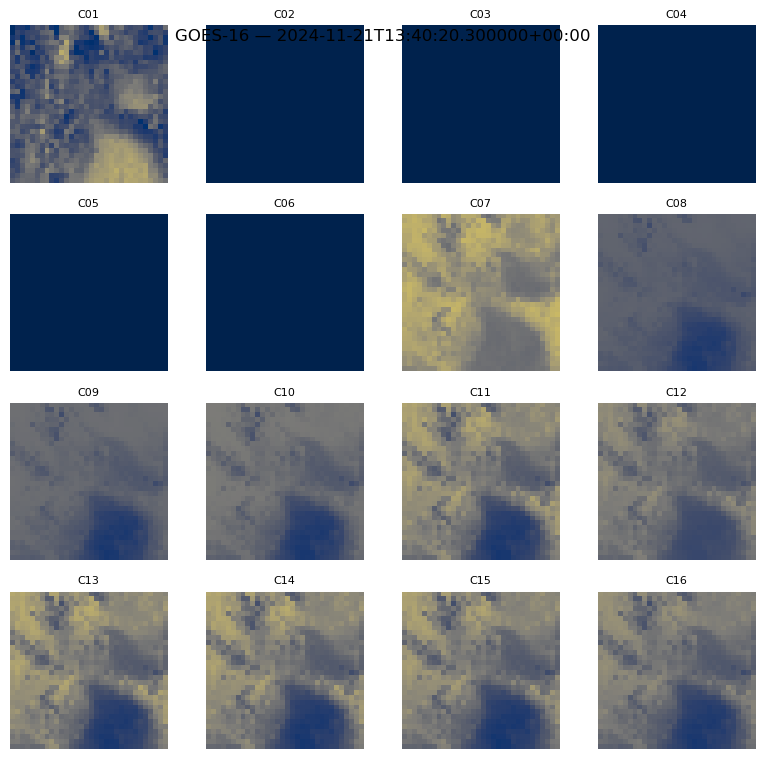

In [13]:
first_ts = sat_raw.index[0]
X0 = np.stack([sat_raw.loc[first_ts, str(ch)] for ch in CHANNELS], axis=0)  # (16,32,32)

fig, axes = plt.subplots(4,4, figsize=(8,8))
for i, ax in enumerate(axes.ravel(), start=1):
    ax.imshow(X0[i-1], vmin=0, vmax=1, cmap="cividis")
    ax.set_title(f"C{i:02d}", fontsize=8); ax.axis("off")
fig.suptitle(f"GOES-16 — {first_ts.isoformat()}", y=0.92)
plt.tight_layout(); plt.show()

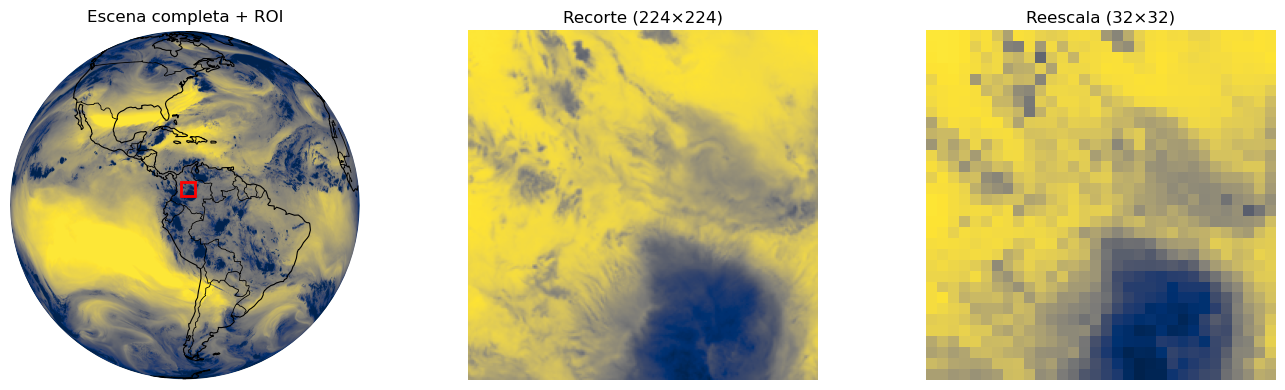

In [14]:
from scipy.ndimage import zoom
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np

# Utilidad mínima
def resize_32(a):
    sy = OUT_SIZE / a.shape[0]; sx = OUT_SIZE / a.shape[1]
    return zoom(a, (sy, sx), order=1).astype("float32")

import pyproj
def lonlat_to_geos_xy(ds, lon, lat):
    gip = ds["goes_imager_projection"]
    sat_h  = float(gip.perspective_point_height)
    lon_0  = float(gip.longitude_of_projection_origin)
    sweep  = str(gip.sweep_angle_axis)
    geos = pyproj.CRS.from_proj4(f"+proj=geos +h={sat_h} +lon_0={lon_0} +sweep={sweep} +ellps=WGS84")
    wgs  = pyproj.CRS.from_epsg(4326)
    P = pyproj.Transformer.from_crs(wgs, geos, always_xy=True)
    return P.transform(lon, lat)

# Abrir primer archivo
nc_demo = FILES[0]
ds = xr.open_dataset(nc_demo)

# Ejes y proyección
sat_h = float(ds["goes_imager_projection"].perspective_point_height)
x = ds["x"].values * sat_h
y = ds["y"].values * sat_h

# Centro ROI → índices
Xc, Yc = lonlat_to_geos_xy(ds, LON, LAT)
ix = int(np.argmin((x - Xc)**2))
iy = int(np.argmin((y - Yc)**2))

half = IN_SIZE // 2
xs = slice(max(ix-half, 0), min(ix+half, x.size))
ys = slice(max(iy-half, 0), min(iy+half, y.size))

# Canal para visualizar (C09 si existe, si no el primero)
var = "CMI_C09" if "CMI_C09" in ds else list(ds.data_vars)[0]
full = ds[var].values
crop = ds[var].isel(x=xs, y=ys).values
# Pad si toca borde
ph, pw = crop.shape
if (ph, pw) != (IN_SIZE, IN_SIZE):
    crop = np.pad(crop, ((0, max(0,IN_SIZE-ph)), (0, max(0,IN_SIZE-pw))), mode="edge")
resized = resize_32(crop)

xmin, xmax = x[xs].min(), x[xs].max()
ymin, ymax = y[ys].min(), y[ys].max()

# Proyección Cartopy
gip = ds["goes_imager_projection"]
proj = ccrs.Geostationary(
    central_longitude=float(gip.longitude_of_projection_origin),
    satellite_height=float(gip.perspective_point_height),
    sweep_axis=str(gip.sweep_angle_axis)
)

# Percentiles para contraste
vmin = np.nanpercentile(full, 5)
vmax = np.nanpercentile(full, 95)

fig = plt.figure(figsize=(14,4))

# 1) Escena completa + ROI
ax1 = fig.add_subplot(1,3,1, projection=proj)
ax1.imshow(full, extent=(x.min(), x.max(), y.min(), y.max()),
           transform=proj, origin="upper", vmin=vmin, vmax=vmax, cmap="cividis")
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.6)
ax1.add_patch(mpatches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                 fill=False, edgecolor="red", linewidth=2, transform=proj))
ax1.set_title("Escena completa + ROI"); ax1.axis("off")

# 2) Recorte 224×224
ax2 = fig.add_subplot(1,3,2, projection=proj)
ax2.imshow(crop, extent=(xmin, xmax, ymin, ymax),
           transform=proj, origin="upper", cmap="cividis")
ax2.set_title("Recorte (224×224)"); ax2.axis("off")

# 3) Reescala 32×32
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(resized, cmap="cividis")
ax3.set_title("Reescala (32×32)"); ax3.axis("off")

plt.tight_layout(); plt.show()
ds.close()


Cobertura por canal (top 5):


C01_mean    1.0
C02_mean    1.0
C03_mean    1.0
C04_mean    1.0
C05_mean    1.0
dtype: float64

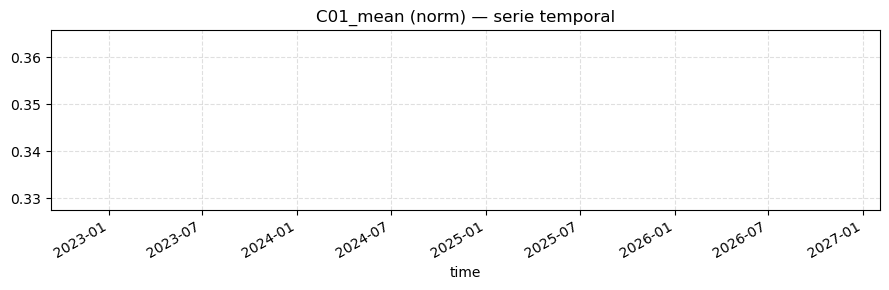

In [15]:
# Diagnóstico rápido de cobertura por canal (mean)
mean_cols = [c for c in sat_feat.columns if c.endswith("_mean")]
cover = pd.Series({c: sat_feat[c].notna().mean() for c in mean_cols}).sort_values(ascending=False)
print("Cobertura por canal (top 5):"); display(cover.head())

# Elige el canal con MÁS datos válidos
best_mean = cover.index[0] if len(cover) else None
if not best_mean:
    print("❌ sat_feat está vacío o sin columnas *_mean.")
else:
    s = sat_feat[best_mean].dropna()
    if s.empty:
        print(f"❌ {best_mean} no tiene datos válidos (todo NaN). Prueba otro canal.")
    else:
        ax = s.plot(figsize=(9,3), lw=1.0, title=f"{best_mean} (norm) — serie temporal")
        ax.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()
